# Poom C's Char-LSTM Langauge Detector
---
This is an char-LSTM for language classifier. The model is standard LSTMs with Dropout and added input noise. The data is taken from *European Parliament Proceedings Parallel Corpus 1996-2011* and the test set is obtained from https://fellowship.ai/challenge/ in late 2017. (Sounds like a macbook pro lol.) The code explains itself.

In [1]:
import re
import os
import random
import numpy as np
import numpy.random as rd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:

def reader(directory):
    """
    Takes 
        - directory : string
            the directory path of all the text files
    Returns 
        - dict[string -> list[string]]
            a dictionary whose keys are the languages (folder-name)
            and values are list of strings in the files in the folder
    """
    def parse(base_name, files):
        print("parsing files in", base_name)
        pattern = re.compile('<[^>]*>')
        strings = []
        for name in files:
            with open(base_name + "/"+ name, errors='replace') as f:
                strings.append(re.sub(pattern, '', f.read().strip()))
        return strings

    def main(directory):
        scanner = os.walk(directory)
        _, folders, _ = next(scanner)
        return {name: parse(name, files)
                for name, _, files in scanner}
    
    return main(directory)

Then we parse the files. This will take sometime. Go get coffee or something.

In [3]:
strings = reader("./text")
joined = { lang: " | ".join(strings[lang])
            for lang in strings }
charset = { lang: set(joined[lang]) for lang in joined }
languages = sorted(charset)


parsing files in ./text/bg
parsing files in ./text/cs
parsing files in ./text/da
parsing files in ./text/de
parsing files in ./text/el
parsing files in ./text/en
parsing files in ./text/es
parsing files in ./text/et
parsing files in ./text/fi
parsing files in ./text/fr
parsing files in ./text/hu
parsing files in ./text/it
parsing files in ./text/lt
parsing files in ./text/lv
parsing files in ./text/nl
parsing files in ./text/pl
parsing files in ./text/pt
parsing files in ./text/ro
parsing files in ./text/sk
parsing files in ./text/sl
parsing files in ./text/sv


In [4]:
num_chars = sum(len(corp) for corp in joined.values())
print("total number of characters:", num_chars)

total number of characters: 4499444944


In [5]:
def stream(joined, window_size, char_to_ind, error_rate=0.001):
    error_ind = char_to_ind["error"]
    languages = sorted(joined)
    labels = [np.repeat(i, window_size) for i in range(len(languages))]
    
    def next_point():
        index = random.randrange(len(languages))
        string = joined[languages[index]]
        start = random.randrange(0, len(string) - window_size)
        substring = string[start:start+window_size]
        
        # add random all upper case and all lower case data 
        #rand = random.random() 
        #if rand > 0.9:
        #    substring = substring.lower()[:window_size]
        # if rand < 0.05:
        #     substring = substring.upper()[:window_size]
        inputs = np.array([char_to_ind[c] for c in substring])
        if error_rate > 0:
            error = rd.binomial(1, error_rate, len(substring))
            mask = error.astype(bool)
            inputs[mask] = error_ind

        return labels[index], inputs

    def iterate(batch_size):
        while True:
            data = [next_point() for _ in range(batch_size)]
            labels, inputs = zip(*data)
            yield np.vstack(labels), np.array(inputs)

    return iterate

In [17]:
unique_char = set(["error"])
for lang in charset:
    unique_char.update(charset[lang])
#unique_char.update([i for c in unique_char for i in c.upper() ])
#unique_char.update([i for c in unique_char for i in c.lower() ])
unique_char = sorted(unique_char)
num_unique_chars = len(unique_char)
char_to_ind = { c : i for i, c in enumerate(unique_char) }
print(num_unique_chars, "unique characters")

497 unique characters


We use a standard Char-LSTM classifier for this problem. That is, we embed characters into $\mathbb{R}^n$, feed the sequence of embedded points into the RNN and have each output be measured against the one-hot language vector using KL divergence. 

We also use dropout in the input layer to improve generalizability and add a 1% random error in the input.

In [18]:
rnn_size = 40
num_layers = 2
batch_size = 30
window_size = 130
output_size = 21

tf.reset_default_graph()

In [19]:
char_ids = tf.placeholder(tf.int64, [batch_size, window_size])
labels   = tf.placeholder(tf.int64, [batch_size, window_size])
pkeep    = tf.placeholder(tf.float64)

In [20]:
weights = np.linspace(0, 1, window_size) ** 0.5

In [21]:
# xavier initialization
embedding = rd.randn(num_unique_chars, rnn_size)
embedding = tf.Variable(embedding / np.sqrt(rnn_size + rnn_size))
inp = tf.nn.embedding_lookup(embedding, char_ids)

# xavier initialization
noise_prob = tf.Variable(np.eye(output_size))
decoder = rd.randn(rnn_size, output_size)
decoder = tf.Variable(decoder / np.sqrt(rnn_size + output_size))
bias    = tf.zeros(output_size, tf.float64)

In [22]:
lstm_cell = lambda size: (
    tf.nn.rnn_cell.DropoutWrapper
   (tf.nn.rnn_cell.LSTMCell(size), pkeep))
# lstm_cell = tf.nn.rnn_cell.LSTMCell
cells = [lstm_cell(rnn_size) for _ in range(num_layers)]
lstm = tf.nn.rnn_cell.MultiRNNCell(cells)

In [23]:
state = lstm.zero_state(batch_size, tf.float64)
outputs = []
for i in range(window_size):
    output, state = lstm(inp[:,i,:], state)
    outputs.append(output)

outputs = tf.stack(outputs, axis=1)
outputs = tf.tensordot(outputs, decoder, [[2], [0]]) + bias

In [24]:
len_index = 100
prediction = tf.argmax(outputs[:, len_index], axis=1),
accuracy = tf.reduce_sum(tf.cast(tf.equal(prediction, labels[:, len_index]), tf.int64))

the next two cells will take some time. please go get another cup of coffee.

In [28]:
longname = tf.nn.sparse_softmax_cross_entropy_with_logits # lol
loss_matrix = longname(logits=outputs, labels=labels)
total_loss = tf.reduce_mean(weights * loss_matrix)

optimizer = tf.train.AdamOptimizer(1e-3)
minimizer = optimizer.minimize(total_loss)

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

since we are training, this cell will also take very long, go get two more cups of coffee.

In [42]:
cumulative = 0.35
datastream = stream(joined, window_size, char_to_ind)(batch_size)
for i in range(500000):
    y, x = next(datastream)
    acc = sess.run([accuracy, minimizer], feed_dict = { char_ids:x, labels:y, pkeep:0.5 })
    cumulative *= 0.99
    cumulative += 0.01 * acc[0] / batch_size
    if i % 200 == 0:
        print("iteration", i, "with decaying accuracy", cumulative)

iteration 0 with decaying accuracy [[ 0.3475      0.34816667  0.35016667  0.3495      0.3495      0.3515
   0.35216667  0.35316667  0.3535      0.35416667  0.3535      0.3535
   0.3535      0.35416667  0.3545      0.35483333  0.3545      0.35416667
   0.35483333  0.3545      0.3555      0.35516667  0.3555      0.3555
   0.3555      0.3555      0.3555      0.3555      0.3555      0.3555
   0.3555      0.3555      0.35583333  0.35583333  0.35616667  0.35616667
   0.35616667  0.35616667  0.35616667  0.3565      0.35616667  0.3565
   0.3565      0.3565      0.3565      0.3565      0.3565      0.3565
   0.3565      0.3565      0.3565      0.3565      0.3565      0.3565
   0.3565      0.3565      0.3565      0.3565      0.3565      0.3565
   0.3565      0.3565      0.3565      0.3565      0.3565      0.3565
   0.3565      0.3565      0.3565      0.3565      0.3565      0.3565
   0.3565      0.3565      0.3565      0.3565      0.3565      0.3565
   0.3565      0.3565      0.3565      0.3565  

In [32]:
prediction = tf.argmax(outputs, axis=2),
accuracy = tf.reduce_sum(tf.cast(tf.equal(prediction, labels), tf.int64), axis=1)

We test internal accuracy using the same data set. We will use another data set to test generalizability.

In [40]:
datastream = stream(joined, window_size, char_to_ind, error_rate=0.0)(batch_size)
cum_acc = 0
for i in range(201):
    y, x = next(datastream)
    [acc] = sess.run([accuracy], feed_dict = { char_ids:x, labels: y, pkeep:1.0 })
    cum_acc += acc[-1] / batch_size
    if i % 200 == 0:
        print("iteration", i, "with total accuracy", cum_acc / (i + 1))

iteration 0 with total accuracy [ 0.13333333  0.26666667  0.33333333  0.26666667  0.3         0.4
  0.53333333  0.53333333  0.6         0.6         0.7         0.7
  0.66666667  0.7         0.8         0.8         0.83333333  0.83333333
  0.83333333  0.83333333  0.86666667  0.86666667  0.86666667  0.86666667
  0.86666667  0.86666667  0.86666667  0.86666667  0.86666667  0.93333333
  0.93333333  0.93333333  0.96666667  0.96666667  0.96666667  0.96666667
  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667  0.93333333
  0.93333333  0.93333333  0.93333333  0.93333333  0.93333333  0.93333333
  0.93333333  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667
  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667
  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667
  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667
  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667  0.96666667
  1.          1.          1.     

Below is the plot of the accuracy of the predictor. 
the x-axis is the length and the y-axis is the accuracy

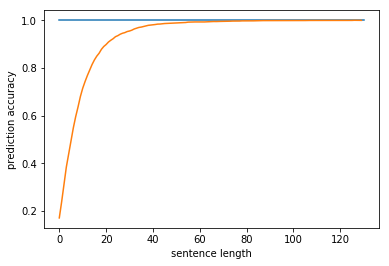

In [46]:
plt.plot([0, 130], [1, 1])
plt.plot(cum_acc / 201)
plt.xlabel("sentence length")
plt.ylabel("prediction accuracy")
plt.show()

In [35]:
def predict(sentence):
    sentence = sentence.strip()
    if len(sentence) > window_size - 3:
        raise ValueError
    
    new_s = "| " + sentence + " " * (window_size - len(sentence) - 2)
    inputs = [char_to_ind[i] 
                if i in char_to_ind 
                else char_to_ind["error"]
                for i in new_s]
    outvec = sess.run(outputs, feed_dict = { 
        char_ids: [inputs] * batch_size,
        labels: [inputs] * batch_size,
        pkeep: 1.0
    })
    outvec = -outvec[0, len(sentence) - 1]
    # print(np.exp(outvec) / np.exp(outvec).sum())
    return [languages[i] for i in np.argsort(outvec)]

In [36]:
import csv
with open("./europarl.test", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    reader = [*reader]

In [37]:
count = len(reader)
correct = 0
errors = []
random.shuffle(reader)
for i, (lab, text) in enumerate(reader):
    p = predict(text[:127])[0]
    correct += lab == p[-2:]
    if lab != p[-2:]:
        print("error", (p[-2:], lab, text))
        errors.append((lab, text))
    
    if i % 1000 == 0:
        print(correct / (i + 1))
print(correct / count)

1.0
error ('da', 'sv', 'Det har fortfarande inte gjorts.')
error ('de', 'en', 'Regarding Amendment No 48')
error ('ro', 'fr', 'Je terminerai cependant sur un appel.')
error ('sk', 'cs', 'Nesmíme toto hledisko opomíjet.')
error ('sk', 'cs', 'Evropští občané mrhají cennými minutami, či dokonce hodinami cestováním.')
error ('sk', 'cs', 'Naprosto souhlasím s panem Maatenem.')
0.994005994005994
error ('pt', 'es', 'Pero afortunadamente sí podemos hacer algo.')
error ('sk', 'cs', 'Úlohou Ruska je zefektivnit své postupy na hranicích.')
error ('sk', 'cs', 'Standard, který vyžadovala Rada Evropy, byl pro všechny stejný a závazný.')
error ('sl', 'sk', 'Rozprava sa skončila.')
error ('es', 'fr', 'Il ne dispose pas de fonds suffisants.')
0.9945027486256871
error ('de', 'nl', 'Water is echter niet gratis.')
error ('sk', 'cs', 'Co tedy tato síť obsahuje?')
error ('it', 'fr', 'Le vote aura lieu mercredi à 11h30.')
error ('nl', 'da', 'Siden 1990 er verdenshandelen vokset eksplosivt.')
error ('de', 'nl

error ('hu', 'da', 'Vi skal tale med én stemme.')
error ('lt', 'es', 'Todas juntas son positivas.')
0.9947666602650278


In [44]:
print(correct, count)

20719 20828
